In [1]:
%matplotlib inline
%load_ext rpy2.ipython

import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import r2_score
from sklearn.metrics import brier_score_loss
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

from scipy import interp
from scipy.interpolate import interp1d

In [2]:
# %load import_notebook.py
# Infraestructure to import a Jupyter notebook
# http://jupyter-notebook.readthedocs.io/en/latest/examples/Notebook/Importing%20Notebooks.html

import io, os, sys, types
from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell

def find_notebook(fullname, path=None):
    """find a notebook, given its fully qualified name and an optional path

    This turns "foo.bar" into "foo/bar.ipynb"
    and tries turning "Foo_Bar" into "Foo Bar" if Foo_Bar
    does not exist.
    """
    name = fullname.rsplit('.', 1)[-1]
    if not path:
        path = ['']
    for d in path:
        nb_path = os.path.join(d, name + ".ipynb")
        if os.path.isfile(nb_path):
            return nb_path
        # let import Notebook_Name find "Notebook Name.ipynb"
        nb_path = nb_path.replace("_", " ")
        if os.path.isfile(nb_path):
            return nb_path
        

class NotebookLoader(object):
    """Module Loader for Jupyter Notebooks"""
    def __init__(self, path=None):
        self.shell = InteractiveShell.instance()
        self.path = path

    def load_module(self, fullname):
        """import a notebook as a module"""
        path = find_notebook(fullname, self.path)

        print ("importing Jupyter notebook from %s" % path)

        # load the notebook object
        with io.open(path, 'r', encoding='utf-8') as f:
            nb = read(f, 4)


        # create the module and add it to sys.modules
        # if name in sys.modules:
        #    return sys.modules[name]
        mod = types.ModuleType(fullname)
        mod.__file__ = path
        mod.__loader__ = self
        mod.__dict__['get_ipython'] = get_ipython
        sys.modules[fullname] = mod

        # extra work to ensure that magics that would affect the user_ns
        # actually affect the notebook module's ns
        save_user_ns = self.shell.user_ns
        self.shell.user_ns = mod.__dict__

        try:
            for cell in nb.cells:
                if cell.cell_type == 'code':
                    # transform the input to executable Python
                    code = self.shell.input_transformer_manager.transform_cell(cell.source)
                    # run the code in themodule
                    exec(code, mod.__dict__)
        finally:
            self.shell.user_ns = save_user_ns
        return mod
    
class NotebookFinder(object):
    """Module finder that locates Jupyter Notebooks"""
    def __init__(self):
        self.loaders = {}

    def find_module(self, fullname, path=None):
        nb_path = find_notebook(fullname, path)
        if not nb_path:
            return

        key = path
        if path:
            # lists aren't hashable
            key = os.path.sep.join(path)

        if key not in self.loaders:
            self.loaders[key] = NotebookLoader(path)
        return self.loaders[key]

sys.meta_path.append(NotebookFinder())

In [3]:
from LogRegUtils import LogRegModel
from LogRegUtils import caldis, calibration_table, calibration, calibration2
from LogRegUtils import create_plots

importing Jupyter notebook from LogRegUtils.ipynb


In [4]:
sel_model = 1 # age + clinical + laboratory model
# sel_model = 2 # age + clinical model
# sel_model = 3 # age + laboratory
# sel_model = 4

if sel_model == 1:
    model_name = 'age+clinical+lab' 
elif sel_model == 2:
    model_name = 'age+clinical' 
elif sel_model == 3:
    model_name = 'age+lab'
elif sel_model == 3:
    model_name = 'clinical-mccormick'
    
low_thres = 0.05
med_thres = 0.25

In [5]:
# Load data, model, generate test dataset, save minmax ranges for coefficients and odd-ratios
isth_data_folder = '../data/2011-15'
isth_data_file = os.path.join(isth_data_folder, 'data.csv')
isth_dict_file = os.path.join(isth_data_folder, 'dictionary.csv')
isth_data = pd.read_csv(isth_data_file, na_values="\\N")

model_params = os.path.join(model_name, 'mice.txt')
model_ranges= os.path.join(model_name, 'minmax.txt')
model_oddratios = os.path.join(model_name, 'oddratios.txt')

model = LogRegModel(model_params)

variables = ['OUT'] + model.names
test_data = isth_data[variables].dropna()
xtest = test_data[test_data.columns[1:]].values

model.saveRanges(xtest, model_ranges)
model.loadVarTypes(isth_data_file, isth_dict_file)
model.saveOddRatios(xtest, model_oddratios)
print model.getFormula(5)

-8.54067 + 0.0435 AGE + 1.01196 SCNS + 2.02945 JAUN + 0.89839 BLDING + 0.00299 AST + 0.14607 CRE + 0.92308 K


### Performance evaluation on complete data

In [6]:
# Performance measures

ytrue = [int(v) for v in test_data[test_data.columns[0]].values]
probs = model.predict(xtest)
ypred = [int(0.5 < p) for p in probs]

auc = roc_auc_score(ytrue, probs)
fpr, tpr, thresholds = roc_curve(ytrue, probs) 
brier = brier_score_loss(ytrue, probs)
cal, dis = caldis(ytrue, probs)
acc = accuracy_score(ytrue, ypred)
precision, recall, f1score, support = precision_recall_fscore_support(ytrue, ypred)
conf = confusion_matrix(ytrue, ypred)

P = N = 0
TP = TN = 0
FP = FN = 0
for i in range(len(ytrue)):
    if ytrue[i] == 1:
        P += 1
        if ypred[i] == 1: TP += 1
        else: FN += 1
    else:
        N += 1
        if ypred[i] == 0: TN += 1
        else: FP += 1
            
sens = float(TP)/P
spec = float(TN)/N

# Positive and Negative Predictive Values
# https://en.wikipedia.org/wiki/Positive_and_negative_predictive_values
ppv = float(TP) / (TP + FP)
npv = float(TN) / (TN + FN)

# Likelihood ratios
# https://en.wikipedia.org/wiki/Likelihood_ratios_in_diagnostic_testing
lr_pos = sens / (1 - spec) if spec < 1 else np.inf
lr_neg = (1 - sens) / spec if 0 < spec else np.inf

# for i in range(len(ytrue)):
#     print i, probs[i], ypred[i], ytrue[i]

# print "True outcomes:", ytrue
# print "Prediction   :", ypred
print "Number of cases:", len(ytrue)
print "CFR            :", 100 * (float(np.sum(ytrue)) / len(ytrue))

print ""
print "Measures of performance"
print "AUC           :", auc
print "Brier         :", brier
print "Calibration   :", cal
print "Discrimination:", dis
print "Accuracy      :", acc
print "Sensitivity   :", sens
print "Specificity   :", spec
print "PPV           :", ppv
print "NPV           :", npv
print "LR+           :", lr_pos
print "LR-           :", lr_neg

with open(os.path.join(model_name, 'internal-eval.txt'), 'w') as of:
    of.write("Measures of performance\n")
    of.write("AUC           : " + str(auc) + "\n")
    of.write("Brier         : " + str(brier) + "\n")
    of.write("Calibration   : " + str(cal) + "\n")
    of.write("Discrimination: " + str(dis) + "\n")
    of.write("Accuracy      : " + str(acc) + "\n")    
    of.write("Sensitivity   : " + str(sens) + "\n")
    of.write("Specificity   : " + str(spec) + "\n")
    of.write("Sensitivity   : " + str(sens) + "\n")
    of.write("Specificity   : " + str(spec) + "\n")    
    of.write("PPV           : " + str(ppv) + "\n")
    of.write("NPV           : " + str(npv) + "\n")
    of.write("LR+           : " + str(lr_pos) + "\n")
    of.write("LR-           : " + str(lr_neg) + "\n")   

Number of cases: 62
CFR            : 22.5806451613

Measures of performance
AUC           : 0.799107142857
Brier         : 0.153397596659
Calibration   : 0.0431477303042
Discrimination: 0.0655629057034
Accuracy      : 0.758064516129
Sensitivity   : 0.285714285714
Specificity   : 0.895833333333
PPV           : 0.444444444444
NPV           : 0.811320754717
LR+           : 2.74285714286
LR-           : 0.797342192691


/Users/andres/anaconda/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/andres/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


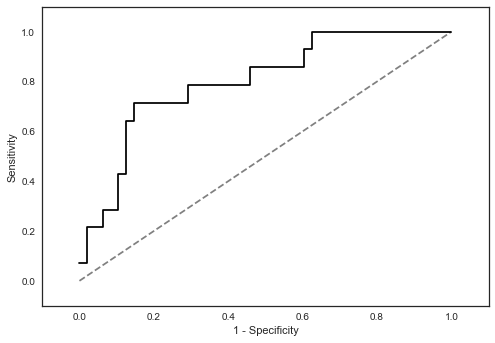

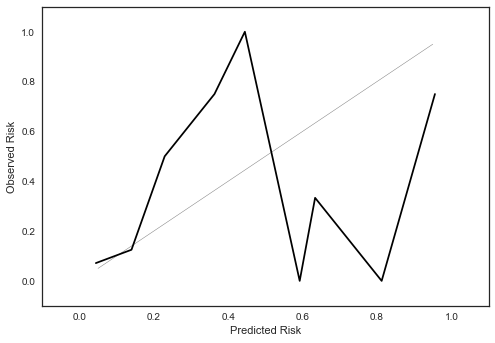

In [7]:
# ROC plot
fpr, tpr, thresholds = roc_curve(ytrue, probs)
fig, ax = plt.subplots()
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.plot([0, 1], [0, 1], 'k--', c='grey')
plt.plot(fpr, tpr, color='black')
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
fig.savefig(os.path.join(model_name, 'internal-roc-complete.pdf'))

# Calibration plot
cal_table = calibration_table(ytrue, probs, 10)
fig, ax = plt.subplots()
plt.plot([0.05, 0.95], [0.05, 0.95], '-', c='grey', linewidth=0.5, zorder=1)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.xlabel('Predicted Risk')
plt.ylabel('Observed Risk')
x = cal_table['pred_prob']
y = cal_table['true_prob']
# f = interp1d(x, y, kind='cubic')
# xnew = np.linspace(min(x), max(x), num=50, endpoint=True)    
# plt.plot(xnew, f(xnew))
plt.plot(x, y, color='black')
fig.savefig(os.path.join(model_name, 'internal-cal-complete.pdf'))

Low 29% 18/62 CFR=0%
Medium 46% 29/62 CFR=17%
High 24% 15/62 CFR=60%


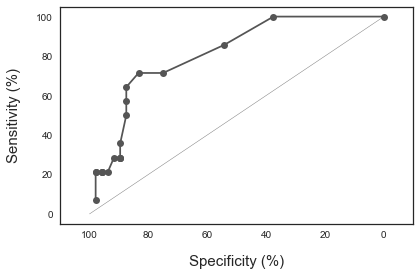

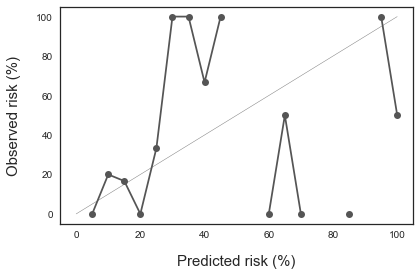

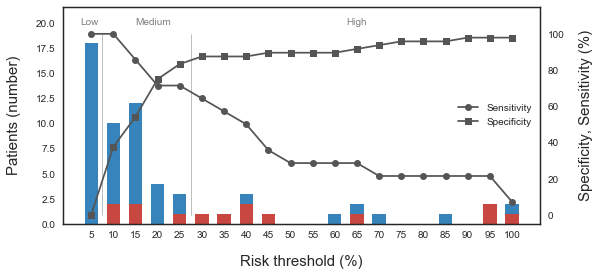

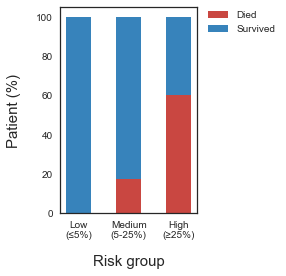

In [8]:
# Sensitivity/specificity for an entire range of thresholds

ncells = 20
thresholds = np.linspace(0.0,  1.0,  ncells + 1)
ytrue = [int(v) for v in test_data[test_data.columns[0]].values]
x = test_data[test_data.columns[1:]].values
probs = model.predict(x)

nt = len(thresholds) - 1
interval = [str(t) + "-" + str(t + 1.0/ncells) for t in thresholds[:-1]]

sensitivity = [[] for n in range(0, nt)]
specificity = [[] for n in range(0, nt)]
surv_count = [[] for n in range(0, nt)]
died_count = [[] for n in range(0, nt)]
for n in range(0, nt):
    t = thresholds[n]
    t1 = thresholds[n + 1]
    ypred = [int(t < p) for p in probs]    
    in_cell = [t < p and p <= t1 for p in probs]    
    nsurv = 0
    ndied = 0    
    P = N = 0
    TP = TN = 0
    for i in range(len(ytrue)):
        if ytrue[i] == 1:            
            P += 1
            if ypred[i] == 1: TP += 1
            if in_cell[i]: ndied += 1
        else:
            N += 1
            if ypred[i] == 0: TN += 1
            if in_cell[i]: nsurv += 1    
            
    sens = float(TP)/P            
    spec = float(TN)/N
    
    sensitivity[n].append(sens)
    specificity[n].append(spec)
    surv_count[n].append(nsurv)
    died_count[n].append(ndied)

sensitivity = [np.mean(sensitivity[n]) for n in range(0, nt)]
specificity = [np.mean(specificity[n]) for n in range(0, nt)]
surv_count = [np.mean(surv_count[n]) for n in range(0, nt)]
died_count = [np.mean(died_count[n]) for n in range(0, nt)]

dfcomp = pd.DataFrame({'Threshold':pd.Series(np.array(thresholds[:-1] + 1.0/ncells)),
                       'Sensitivity':pd.Series(np.array(sensitivity)),
                       'Specificity':pd.Series(np.array(specificity)),                          
                       'Survival':pd.Series(np.array(surv_count)),
                       'Mortality':pd.Series(np.array(died_count))}, 
                        columns=['Threshold', 'Sensitivity', 'Specificity', 
                                 'Survival', 'Mortality'])

dfcomp.to_csv(os.path.join(model_name, 'sens-spec-complete.csv'))    
create_plots(model_name, dfcomp, low_thres, med_thres, 'complete')

### Calculations and plots on imputed data

In [9]:
# Odd-ratios with 95% CI
ci_critical_value = 1.96 # For 95% CI 

boot_folder = os.path.join(model_name, 'boot')
imp_folder = os.path.join(model_name, 'imp')

odds_values = {}
data_files = glob.glob(imp_folder + '/imputation-*.csv')
for fn in data_files:    
    dat = pd.read_csv(fn, na_values="\\N")[variables]
    val = dat[dat.columns[1:]].values
    
    pos0 = fn.index("imputation-") + 11
    pos1 = fn.index(".csv")
    idx = fn[pos0:pos1]
    
    odds_boot = {}
    index_files = glob.glob(boot_folder + '/index-' + idx + '-*.txt')
    model_files = glob.glob(boot_folder + '/model-' + idx + '-*.txt')
    nboot = len(index_files)
    for b in range(0, nboot): 
        rows = []
        with open(index_files[b]) as ifile:
            lines = ifile.readlines()
            for line in lines:
                pieces = line.split()[1:]
                rows += [int(i) - 1 for i in pieces]
        
        model = LogRegModel(model_files[b], model_format='GLM')
        model.loadVarTypes(isth_data_file, isth_dict_file)
        odds = model.getOddRatios(xtest)
        for k in odds:
            if not k in odds_boot: odds_boot[k] = 0
            odds_boot[k] += odds[k]

    for k in odds_boot:  
        odds_boot[k] = odds_boot[k] / nboot
    for k in odds_boot:
        if not k in odds_values: odds_values[k] = []
        if 0 < odds_boot[k] and odds_boot[k] < 100:
            odds_values[k] = odds_values[k] + [odds_boot[k]]

# Loading the model's odds
odds_model = {}
with open(model_oddratios) as f:
    lines = f.readlines()
    for line in lines:
        pieces = line.split()
        odds_model[pieces[0]] = pieces[1] 

# Adding the CIs to the model's file
with open(model_oddratios, 'w') as f:
    for k in odds_values:
        mean_odds = np.mean(odds_values[k])
        std_odds = np.std(odds_values[k])        
        ci_odds = [mean_odds - ci_critical_value * std_odds, mean_odds + ci_critical_value * std_odds]
        odds_model[k] = odds_model[k] + ' (' + str(ci_odds[0]) + ', ' + str(ci_odds[1]) + ')'    
        print k, odds_model[k]
        f.write(k + ' ' + odds_model[k] + '\n')

AST 1.48618056547 (0.743217605128, 2.53062005604)
AGE 1.54494730041 (1.3831321782, 1.80809556325)
CRE 1.33929639808 (1.07441279031, 1.73690992979)
BLDING 2.45564380689 (1.6852503231, 3.96900265376)
JAUN 7.60992791938 (0.717859825773, 22.9684668437)
SCNS 2.75099050372 (1.37284195879, 5.74238290143)
K 3.6412149011 (2.21580177625, 6.44699870958)


Mean AUC: 0.864639103167
95% CI: [0.82554884381012883, 0.90372936252324632]


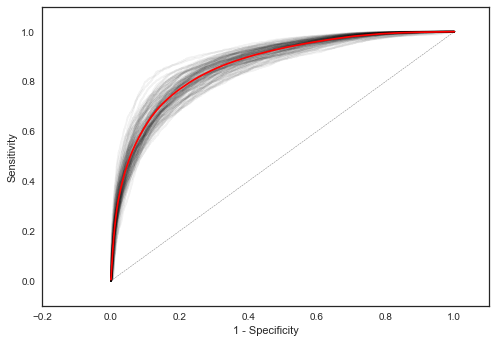

In [10]:
# Averaged ROC curve

ci_critical_value = 1.96 # For 95% CI 

boot_folder = os.path.join(model_name, 'boot')
imp_folder = os.path.join(model_name, 'imp')

fig, ax = plt.subplots()
plt.xlim([-0.2, 1.1])
plt.ylim([-0.1, 1.1])
plt.plot([0, 1], [0, 1], 'k--', c='grey', linewidth=0.5)
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')

data_files = glob.glob(imp_folder + '/imputation-*.csv')
imp_fpr = []
imp_tpr = []
auc_values = []
for fn in data_files:    
    dat = pd.read_csv(fn, na_values="\\N")[variables]
    val = dat[dat.columns[1:]].values
    
    pos0 = fn.index("imputation-") + 11
    pos1 = fn.index(".csv")
    idx = fn[pos0:pos1]
    
    index_files = glob.glob(boot_folder + '/index-' + idx + '-*.txt')
    model_files = glob.glob(boot_folder + '/model-' + idx + '-*.txt')
    
    # Micro-averaging the ROC curves from bootstrap samples:
    # http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
    ytrue = []
    probs = []
    ypred = []
    nboot = len(index_files)
    for b in range(0, nboot):        
        rows = []
        with open(index_files[b]) as ifile:
            lines = ifile.readlines()
            for line in lines:
                pieces = line.split()[1:]
                rows += [int(i) - 1 for i in pieces]

        ytrue += [int(v) for v in dat[dat.columns[0]].values[rows]]
        x = val[rows,:]
        model = LogRegModel(model_files[b], model_format='GLM')
        pboot = model.predict(x)
        probs += list(pboot)
        ypred += [int(0.5 < p) for p in pboot]

    auc = roc_auc_score(ytrue, probs)
    fpr, tpr, thresholds = roc_curve(ytrue, probs) 
    plt.plot(fpr, tpr, color='black', alpha=0.05)
    imp_fpr += [fpr]
    imp_tpr += [tpr]
    auc_values += [auc]

# Macro-average of ROC cuve over all imputations.

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate(imp_fpr))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(0, len(imp_fpr)):
    mean_tpr += interp(all_fpr, imp_fpr[i], imp_tpr[i])
mean_tpr /= len(imp_fpr)

# mean_auc = metrics.auc(all_fpr, mean_tpr)
mean_auc = np.mean(auc_values)
std_auc = np.std(auc_values)
ci_auc = [mean_auc - ci_critical_value * std_auc, mean_auc + ci_critical_value * std_auc]
print "Mean AUC:", mean_auc
print "95% CI:", ci_auc

with open(os.path.join(model_name, 'average-roc-bootstrap.txt'), 'w') as f:
    f.write(str(mean_auc) + ' (' + str(ci_auc[0]) + ',' + str(ci_auc[1]) +')')

plt.plot(all_fpr, mean_tpr, color='red', alpha=1.0)

fig.savefig(os.path.join(model_name, 'average-roc-bootstrap.pdf'))

Mean calibration: 0.0803479751446
95% CI: [0.043164924569730485, 0.11753102571947252]


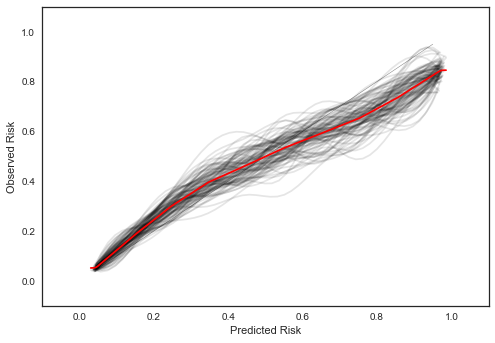

In [11]:
# Average calibration plot

boot_folder = os.path.join(model_name, 'boot')
imp_folder = os.path.join(model_name, 'imp')

fig, ax = plt.subplots()
# plt.plot([0, 1], [0, 1], '-', c='grey', linewidth=0.8 * 1, zorder=1)
plt.plot([0.05, 0.95], [0.05, 0.95], '-', c='grey', linewidth=0.5, zorder=1)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.xlabel('Predicted Risk')
plt.ylabel('Observed Risk')
# lgnd = plt.legend(loc='lower right', scatterpoints=1, fontsize=10) 

data_files = glob.glob(imp_folder + '/imputation-*.csv')
imp_ppr = []
imp_tpr = []
cal_values = []
for fn in data_files:    
    dat = pd.read_csv(fn, na_values="\\N")[variables]
    val = dat[dat.columns[1:]].values
    
    pos0 = fn.index("imputation-") + 11
    pos1 = fn.index(".csv")
    idx = fn[pos0:pos1]
    
    index_files = glob.glob(boot_folder + '/index-' + idx + '-*.txt')
    model_files = glob.glob(boot_folder + '/model-' + idx + '-*.txt')
    
    ytrue = []
    probs = []
    ypred = []    
    nboot = len(index_files)
    for b in range(0, nboot):        
        rows = []
        with open(index_files[b]) as ifile:
            lines = ifile.readlines()
            for line in lines:
                pieces = line.split()[1:]
                rows += [int(i) - 1 for i in pieces]

        ytrue += [int(v) for v in dat[dat.columns[0]].values[rows]]
        x = val[rows,:]
        model = LogRegModel(model_files[b], model_format='GLM')
        pboot = model.predict(x)
        probs += list(pboot)
        ypred += [int(0.5 < p) for p in pboot]
    
    cal_table = calibration_table(ytrue, probs, 10)
    cal_values += [np.sqrt(calibration2(ytrue, probs, 10))]
#     sizes = cal_table['count'] / 20
#     plt.scatter(cal_table['pred_prob'], cal_table['true_prob'], s=sizes, c='red', marker='o', lw = 0, alpha=0.8, zorder=2)

    x = cal_table['pred_prob']
    y = cal_table['true_prob']
    f = interp1d(x, y, kind='cubic')
    xnew = np.linspace(min(x), max(x), num=50, endpoint=True)    
    plt.plot(xnew, f(xnew), color='black', alpha=0.1)    
    imp_ppr += [x]
    imp_tpr += [y]

all_ppr = np.unique(np.concatenate(imp_ppr))

mean_tpr = np.zeros_like(all_ppr)
for i in range(0, len(imp_ppr)):
    mean_tpr += interp(all_ppr, imp_ppr[i], imp_tpr[i])
mean_tpr /= len(imp_ppr)

# Won't use the mean of the cal_values obtaned from each bootstrap sample because they have, in general,
# non-uniform occupancy of the bins, so this result in abnormally low estimates of calibration, specially
# if those with high discrepancies between 
# Aggregating all predictions allow to have good occupancy, but the calibration calculation is done within
# each boostrap, so we just use the average results for the predicted and true probabilities. Also, we take 
# the square root of the calibration, so it really represents the average difference between both curves

# v = np.array(all_ppr - mean_tpr)
# mean_cal = np.sqrt(np.mean(v * v))
# print "Mean calibration:", mean_cal

mean_cal = np.mean(cal_values)
std_cal = np.std(cal_values)
ci_cal = [mean_cal - ci_critical_value * std_cal, mean_cal + ci_critical_value * std_cal]
print "Mean calibration:", mean_cal
print "95% CI:", ci_cal

with open(os.path.join(model_name, 'average-calibration-bootstrap.txt'), 'w') as f:
    f.write(str(mean_cal) + ' (' + str(ci_cal[0]) + ',' + str(ci_cal[1]) +')')

xnew = np.linspace(min(all_ppr), max(all_ppr), num=2 * len(all_ppr), endpoint=True)    
f = interp1d(all_ppr, mean_tpr, kind='cubic')    
plt.plot(xnew, f(xnew), color='red', alpha=1.0)

fig.savefig(os.path.join(model_name, 'average-calibration-bootstrap.pdf'))

In [12]:
# Final performance figures for paper

ncells = 20
thresholds = np.linspace(0.0,  1.0,  ncells + 1)
nt = len(thresholds) - 1
sensitivity = [[] for n in range(0, nt)]
specificity = [[] for n in range(0, nt)]
surv_count = [[] for n in range(0, nt)]
died_count = [[] for n in range(0, nt)]

boot_folder = os.path.join(model_name, 'boot')
imp_folder = os.path.join(model_name, 'imp')

data_files = glob.glob(imp_folder + '/imputation-*.csv')
imp_ppr = []
imp_tpr = []
for fn in data_files:    
    dat = pd.read_csv(fn, na_values="\\N")[variables]
    val = dat[dat.columns[1:]].values
    
    pos0 = fn.index("imputation-") + 11
    pos1 = fn.index(".csv")
    idx = fn[pos0:pos1]
    
    index_files = glob.glob(boot_folder + '/index-' + idx + '-*.txt')
    model_files = glob.glob(boot_folder + '/model-' + idx + '-*.txt')
    
    ytrue = []
    probs = []
    ypred = []    
    nboot = len(index_files)
    for b in range(0, nboot):        
        rows = []
        with open(index_files[b]) as ifile:
            lines = ifile.readlines()
            for line in lines:
                pieces = line.split()[1:]
                rows += [int(i) - 1 for i in pieces]

        ytrue = [int(v) for v in dat[dat.columns[0]].values[rows]]
        x = val[rows,:]
        model = LogRegModel(model_files[b], model_format='GLM')
        probs = model.predict(x)
        
        for n in range(0, nt):
            t = thresholds[n]
            t1 = thresholds[n + 1]
            ypred = [int(t < p) for p in probs]    
            in_cell = [t < p and p <= t1 for p in probs]    
            nsurv = 0
            ndied = 0    
            P = N = 0
            TP = TN = 0
            for i in range(len(ytrue)):
                if ytrue[i] == 1:            
                    P += 1
                    if ypred[i] == 1: TP += 1
                    if in_cell[i]: ndied += 1
                else:
                    N += 1
                    if ypred[i] == 0: TN += 1
                    if in_cell[i]: nsurv += 1            
            sens = float(TP)/P            
            spec = float(TN)/N
    
            sensitivity[n].append(sens)
            specificity[n].append(spec)
            surv_count[n].append(nsurv)
            died_count[n].append(ndied)        
    
sensitivity = [np.mean(sensitivity[n]) for n in range(0, nt)]
specificity = [np.mean(specificity[n]) for n in range(0, nt)]
surv_count = [np.mean(surv_count[n]) for n in range(0, nt)]
died_count = [np.mean(died_count[n]) for n in range(0, nt)]

dfboot = pd.DataFrame({'Threshold':pd.Series(np.array(thresholds[:-1] + 1.0/ncells)), 
                       'Sensitivity':pd.Series(np.array(sensitivity)),
                       'Specificity':pd.Series(np.array(specificity)),                          
                       'Survival':pd.Series(np.array(surv_count)),
                       'Mortality':pd.Series(np.array(died_count))}, 
                        columns=['Threshold', 'Sensitivity', 'Specificity', 
                                 'Survival', 'Mortality'])

dfboot.to_csv(os.path.join(model_name, 'sens-spec-bootstrap.csv'))    

Low 30% 32/105 CFR=2%
Medium 40% 42/105 CFR=14%
High 29% 31/105 CFR=59%


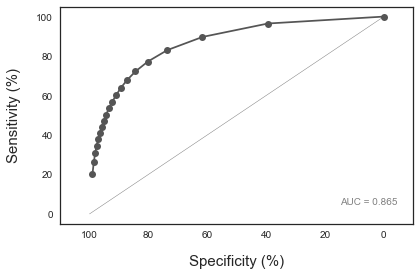

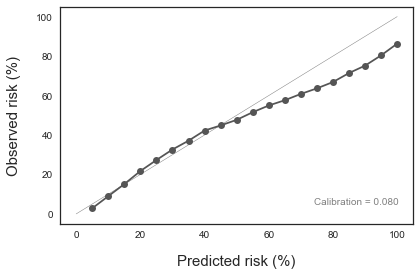

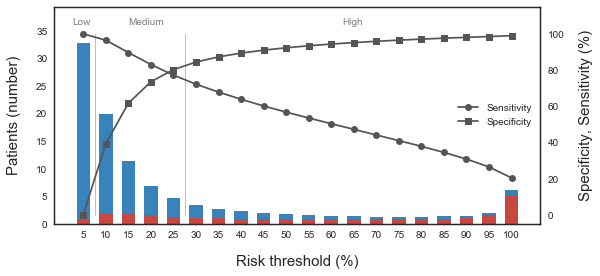

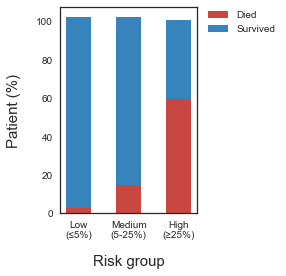

In [13]:
create_plots(model_name, dfboot, low_thres, med_thres, 'bootstrap', mean_auc, mean_cal)